In [1]:
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cftime

import xarray
import dask

In [2]:
dask.config.set(scheduler="processes")

# IA monthly and ESGF-VA

In [3]:
url = "https://github.com/SantanderMetGroup/ATLAS/raw/refs/heads/main/warming-levels/CMIP6_Atlas_WarmingLevels.csv"
gwls_file = url.split("/")[-1]
with open(gwls_file, "w") as f:
    response = requests.get(url)
    response.raise_for_status()
    f.write(response.text)
gwls = pd.read_csv(gwls_file)

In [14]:
gwls["model_run"]

0           ACCESS-CM2_r1i1p1f1
1        ACCESS-ESM1-5_r1i1p1f1
2        AWI-CM-1-1-MR_r1i1p1f1
3          BCC-CSM2-MR_r1i1p1f1
4          CAMS-CSM1-0_r2i1p1f1
5              CanESM5_r1i1p1f1
6                CESM2_r4i1p1f1
7          CESM2-WACCM_r1i1p1f1
8         CMCC-CM2-SR5_r1i1p1f1
9           CNRM-CM6-1_r1i1p1f2
10       CNRM-CM6-1-HR_r1i1p1f2
11         CNRM-ESM2-1_r1i1p1f2
12           EC-Earth3_r1i1p1f1
13       EC-Earth3-Veg_r1i1p1f1
14    EC-Earth3-Veg-LR_r1i1p1f1
15           FGOALS-g3_r1i1p1f1
16            GFDL-CM4_r1i1p1f1
17           GFDL-ESM4_r1i1p1f1
18     HadGEM3-GC31-LL_r1i1p1f3
19            IITM-ESM_r1i1p1f1
20           INM-CM4-8_r1i1p1f1
21           INM-CM5-0_r1i1p1f1
22        IPSL-CM6A-LR_r1i1p1f1
23          KACE-1-0-G_r2i1p1f1
24           KIOST-ESM_r1i1p1f1
25          MIROC-ES2L_r1i1p1f2
26              MIROC6_r1i1p1f1
27       MPI-ESM1-2-HR_r1i1p1f1
28       MPI-ESM1-2-LR_r1i1p1f1
29          MRI-ESM2-0_r1i1p1f1
30               NESM3_r1i1p1f1
31      

Version was extracted from https://raw.githack.com/IPCC-WG1/Atlas/devel/data-sources/CMIP6/CMIP6.html.

In [5]:
# daily
esgf_va_catalog = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip")

versions = {
    "ACCESS-CM2": "v20191108",
    "ACCESS-ESM1-5": "v20191115",
    "AWI-CM-1-1-MR": "v20190529",
    # "BCC-CSM2-MR": "v20190318", # time units change in across netCDFs
    "CAMS-CSM1-0": "v20191106",
    "CanESM5": "v20190429",
    #"CESM2": "v20200702",
    "CESM2-WACCM": "v20200702",
    "CMCC-CM2-SR5": "v20200622",
    "CNRM-CM6-1": "v20190219",
    "CNRM-CM6-1-HR": "v20191202",
    "CNRM-ESM2-1": "v20191021",
    "EC-Earth3": "v20200310",
    #"EC-Earth3-Veg": "v20200225",
    #"EC-Earth3-Veg-LR": "", # no pr
    "FGOALS-g3": "v20190818",
    #"GFDL-CM4": "v20180701",
    #"GFDL-ESM4": "v20180701",
    "HadGEM3-GC31-LL": "v20200114",
    "IITM-ESM": "v20200915",
    #"INM-CM4-8": "v20190603",
    #"INM-CM5-0": "v20190724",
    "IPSL-CM6A-LR": "v20190903",
    #"KACE-1-0-G": "v20191011",
    #"KIOST-ESM": "v20191106",
    "MIROC-ES2L": "v20200318",
    #"MIROC6": "v20191016",
    "MPI-ESM1-2-HR": "v20190710",
    #"MPI-ESM1-2-LR": "v20190710",
    #"MRI-ESM2-0": "v20191108",
    #"NESM3": "v20190811",
    "NorESM2-LM": "v20191108",
    #"NorESM2-MM": "v20191108",
    "TaiESM1": "v20200902",
    #"UKESM1-0-LL": "v20190726",
}

replicas = {
    "ACCESS-CM2": "esgf.ceda.ac.uk",
    "ACCESS-ESM1-5": "esgf.ceda.ac.uk",
    "AWI-CM-1-1-MR": "esgf.ceda.ac.uk",
    #"BCC-CSM2-MR": "esgf.ceda.ac.uk",
    "CAMS-CSM1-0": "esgf.ceda.ac.uk",
    "CanESM5": "esgf.ceda.ac.uk",
    #"CESM2": "esgf.ceda.ac.uk",
    "CESM2-WACCM": "esgf.ceda.ac.uk",
    "CMCC-CM2-SR5": "esgf.ceda.ac.uk",
    "CNRM-CM6-1": "esgf.ceda.ac.uk",
    "CNRM-CM6-1-HR": "esgf.ceda.ac.uk",
    "CNRM-ESM2-1": "esgf.ceda.ac.uk",
    "EC-Earth3": "esgf.ceda.ac.uk",
    #"EC-Earth3-Veg": "esgf3.dkrz.de",
    "EC-Earth3-Veg-LR": "esgf.ceda.ac.uk",
    "FGOALS-g3": "esgf.ceda.ac.uk",
    #"GFDL-CM4": "esgf.ceda.ac.uk",
    #"GFDL-ESM4": "esgf.ceda.ac.uk",
    "HadGEM3-GC31-LL": "esgf-data1.llnl.gov",
    "IITM-ESM": "esgf.ceda.ac.uk",
    #"INM-CM4-8": "esgf.ceda.ac.uk",
    #"INM-CM5-0": "esgf.ceda.ac.uk",
    "IPSL-CM6A-LR": "esgf.ceda.ac.uk",
    #"KACE-1-0-G": "esgf.ceda.ac.uk",
    #"KIOST-ESM": "esgf.ceda.ac.uk",
    "MIROC-ES2L": "esgf.nci.org.au",
    #"MIROC6": "esgf.ceda.ac.uk",
    "MPI-ESM1-2-HR": "esgf.ceda.ac.uk",
    #"MPI-ESM1-2-LR": "esgf.ceda.ac.uk",
    #"MRI-ESM2-0": "esgf.ceda.ac.uk",
    #"NESM3": "esgf.ceda.ac.uk",
    "NorESM2-LM": "esgf.ceda.ac.uk",
    #"NorESM2-MM": "esgf.ceda.ac.uk",
    "TaiESM1": "esgf.ceda.ac.uk",
    #"UKESM1-0-LL": "esgf.ceda.ac.uk",
}

members = gwls["model_run"].str.split("_", expand=True).set_index(0)[1].to_dict()

/tmp/ipykernel_1628035/2172351578.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  esgf_va_catalog = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip")


In [6]:
def load_datasets(experiment, esgf_va_catalog, versions, replicas, members):
    # obtain the locations
    locations = []
    for model in members:
        if model in versions:
            member = members[model]
            subset = esgf_va_catalog.query(f"project == 'CMIP6' & model == '{model}' & table == 'day' & variable == 'pr' & experiment == '{experiment}' & replica == '{replicas[model]}' & version == '{versions[model]}'")
            if len(subset) > 0:
                locations.append(subset.iloc[0,0])
            else:
                print(f"Missing {model}")

    # load xarray datasets
    dss = []
    for location in locations:
        name = location.split("/")[-1]
        model = name.split("_")[3]
    
        print(f"Loading {location}")
        
        ds = xarray.open_dataset(
            location,
            drop_variables=["tracking_id", "further_info_url", "time_bnds", "lat_bnds", "lon_bnds"]).sel(
            variant_label=members[model].encode("ascii")).isel(
            time=slice(None, 31390))
    
        # limit to 2100, avoid cf time indexding issues
        if isinstance(ds["time"][0].item(), cftime.Datetime360Day):
            ds = ds.sel(time=slice("20150101", "21001230"))
        else:
            ds = ds.sel(time=slice("20150101", "21001231"))
    
        # add the model_run global attribute
        ds.attrs["model_run"] = f"{model}_{members[model]}"
    
        dss.append(ds)

    return dss

In [7]:
dss = load_datasets("ssp585", esgf_va_catalog, versions, replicas, members)

Loading https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp585_day_gn_v20191108/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp585_day_pr_gn_v20191108.ncml
Loading https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CSIRO_ACCESS-ESM1-5_ssp585_day_gn_v20191115/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CSIRO_ACCESS-ESM1-5_ssp585_day_pr_gn_v20191115.ncml
Loading https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_AWI_AWI-CM-1-1-MR_ssp585_day_gn_v20190529/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_AWI_AWI-CM-1-1-MR_ssp585_day_pr_gn_v20190529.ncml
Loading https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CAMS_CAMS-CSM1-0_ssp585_day_gn_v20191106/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CAMS_CAMS-CSM1-0_ssp585_day_pr_gn_v20191106.ncml
Loading https://hub.ipcc.ifca.es/t

/tmp/ipykernel_1628035/1788440637.py:21: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xarray.open_dataset(
/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


Loading https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CMCC_CMCC-CM2-SR5_ssp585_day_gn_v20200622/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CMCC_CMCC-CM2-SR5_ssp585_day_pr_gn_v20200622.ncml
Loading https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp585_day_gr_v20190219/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp585_day_pr_gr_v20190219.ncml
Loading https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1-HR_ssp585_day_gr_v20191202/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1-HR_ssp585_day_pr_gr_v20191202.ncml
Loading https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-ESM2-1_ssp585_day_gr_v20191021/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-ESM2-1_ssp585_day_pr_gr_v20191021.ncml
Load

Print size of the datasets:

In [8]:
for ds in dss:
    print(f'{ds["pr"].size * ds["pr"].dtype.itemsize / 2**20:.2f} MB')

3310.66 MB
3333.65 MB
8828.44 MB
6063.67 MB
980.94 MB
6621.33 MB
6621.33 MB
3923.75 MB
31037.48 MB
3923.75 MB
15695.00 MB
1724.30 MB
3265.31 MB
2137.44 MB
2465.76 MB
980.94 MB
8828.44 MB
1655.33 MB
6621.33 MB


Do the same for the historical period.

In [12]:
historicals = load_datasets("historical", esgf_va_catalog, versions, replicas, members)

Missing AWI-CM-1-1-MR
Missing CAMS-CSM1-0
Missing CESM2-WACCM
Missing CMCC-CM2-SR5
Missing CNRM-CM6-1
Missing CNRM-CM6-1-HR
Missing CNRM-ESM2-1
Missing FGOALS-g3
Missing HadGEM3-GC31-LL
Missing IITM-ESM
Missing IPSL-CM6A-LR
Missing NorESM2-LM
Missing TaiESM1
Loading https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CSIRO-ARCCSS_ACCESS-CM2_historical_day_gn_v20191108/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CSIRO-ARCCSS_ACCESS-CM2_historical_day_pr_gn_v20191108.ncml
Loading https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CSIRO_ACCESS-ESM1-5_historical_day_gn_v20191115/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CSIRO_ACCESS-ESM1-5_historical_day_pr_gn_v20191115.ncml
Loading https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CCCma_CanESM5_historical_day_gn_v20190429/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CCCma_CanESM5_historical_day_pr_gn_v20190429.ncml
Loading https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ense

KeyError: "not all values found in index 'variant_label'. Try setting the `method` keyword argument (example: method='nearest')."

Heavy computation (lo interesante sería hacer esto con Pangeo tambn).

Need to be careful how to retrieve the Europe subset based on `(0, 360)`.

In [10]:
def efficient_retrieval_and_compute(ds):
    lats, lons = slice(35, 72), slice(-11, 35) # Europe in (-180, 180)

    # handle Europe being split when using (0, 360)
    if ds["lon"].min().item() >= 0:
        left = ds.sel(lon=slice(0, 36), lat=lats).chunk({"time": 1000})
        right = ds.sel(lon=slice(348, 360), lat=lats).chunk({"time": 1000})

        spatial = xarray.concat([left, right], dim="lon")
    else:
        spatial = ds.sel(lon=lons, lat=lats)

    winter = spatial.sel(time=spatial.time.dt.month.isin([12,1,2])).resample({"time": "MS"}).sum().load()
    winter = winter.assign_coords(lon=((winter["lon"] + 180) % 360) - 180).sortby("lon")

    return winter

In [11]:
%%time

a = efficient_retrieval_and_compute(dss[0])

CPU times: user 8.9 s, sys: 1.49 s, total: 10.4 s
Wall time: 20.9 s


In [16]:
%%time

dss2 = [efficient_retrieval_and_compute(ds) for ds in dss]

CPU times: user 3min 17s, sys: 50.1 s, total: 4min 7s
Wall time: 16min 15s


In [17]:
dss2[0]["pr"].shape, dss2[1]["pr"].shape, dss2[2]["pr"].shape

((1032, 30, 25), (1032, 30, 26), (1032, 40, 51))

In [21]:
for ds in dss2:
    print(f'{ds["pr"].size * ds["pr"].dtype.itemsize / 2**20:.2f} MB')

2.95 MB
3.07 MB
8.03 MB
5.52 MB
0.87 MB
5.83 MB
5.83 MB
3.48 MB
28.26 MB
3.48 MB
14.40 MB
1.77 MB
2.95 MB
2.02 MB
2.17 MB
0.87 MB
8.03 MB
1.50 MB
5.83 MB


In [7]:
locations = []
for model in members:
    if model in versions:
        member = members[model]
        subset = esgf_va_catalog.query(f"project == 'CMIP6' & model == '{model}' & table == 'day' & variable == 'pr' & experiment == 'ssp585' & replica == '{replicas[model]}' & version == '{versions[model]}'")
        if len(subset) > 0:
            locations.append(subset.iloc[0,0])
        else:
            print(f"Missing {model}")

In [8]:
locations

['https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp585_day_gn_v20191108/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp585_day_pr_gn_v20191108.ncml',
 'https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CSIRO_ACCESS-ESM1-5_ssp585_day_gn_v20191115/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CSIRO_ACCESS-ESM1-5_ssp585_day_pr_gn_v20191115.ncml',
 'https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_AWI_AWI-CM-1-1-MR_ssp585_day_gn_v20190529/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_AWI_AWI-CM-1-1-MR_ssp585_day_pr_gn_v20190529.ncml',
 'https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CAMS_CAMS-CSM1-0_ssp585_day_gn_v20191106/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CAMS_CAMS-CSM1-0_ssp585_day_pr_gn_v20191106.ncml',
 'https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/en

In [9]:
len(locations)

19

In [11]:
lats, lons = slice(35, 72), slice(-11, 35) # Europe
lons360 = (slice(349, 360), (0, 35))

dss = []
for location in locations:
    name = location.split("/")[-1]
    model = name.split("_")[3]

    print(location)
    
    ds = xarray.open_dataset(
        location,
        drop_variables=["tracking_id", "further_info_url", "time_bnds", "lat_bnds", "lon_bnds"]).sel(
        variant_label=members[model].encode("ascii")).isel(
        time=slice(None, 31390))

    # limit to 2100, avoid cf time indexding issues
    #ds["time"] = ds["time"].astype("datetime64[ns]")
    if isinstance(ds["time"][0].item(), cftime.Datetime360Day):
        ds = ds.sel(time=slice("20150101", "21001230"))
    else:
        ds = ds.sel(time=slice("20150101", "21001231"))

    # add the model_run global attribute
    ds.attrs["model_run"] = f"{model}_{members[model]}"

    #ds = ds.sel(lat=lats, time=ds.time.dt.month.isin([12,1,2]))

    dss.append(ds)

https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp585_day_gn_v20191108/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp585_day_pr_gn_v20191108.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CSIRO_ACCESS-ESM1-5_ssp585_day_gn_v20191115/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CSIRO_ACCESS-ESM1-5_ssp585_day_pr_gn_v20191115.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_AWI_AWI-CM-1-1-MR_ssp585_day_gn_v20190529/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_AWI_AWI-CM-1-1-MR_ssp585_day_pr_gn_v20190529.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CAMS_CAMS-CSM1-0_ssp585_day_gn_v20191106/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CAMS_CAMS-CSM1-0_ssp585_day_pr_gn_v20191106.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/Scena

/tmp/ipykernel_1601377/73726757.py:11: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xarray.open_dataset(
/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CMCC_CMCC-CM2-SR5_ssp585_day_gn_v20200622/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CMCC_CMCC-CM2-SR5_ssp585_day_pr_gn_v20200622.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp585_day_gr_v20190219/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp585_day_pr_gr_v20190219.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1-HR_ssp585_day_gr_v20191202/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1-HR_ssp585_day_pr_gr_v20191202.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-ESM2-1_ssp585_day_gr_v20191021/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-ESM2-1_ssp585_day_pr_gr_v20191021.ncml
https://hub.ipcc.ifca.es/thredds/dod

# To concat we need first to interpolate.

In [109]:
dss_interp = [ds.interp(
    lat=iad["lat"],
    lon=iad["lon"],
    method="linear",
    kwargs={"fill_value": "extrapolate"})
              for ds in dss2]

In [110]:
for ds in dss_interp:
    ds["time"] = ds["time"].astype("datetime64[ns]")

In [111]:
cmip6_ssp585 = xarray.concat(
    dss_interp,
    xarray.Variable("member", [ds.attrs["model_run"] for ds in dss_interp]))

In [112]:
cmip6_ssp585

<xarray.Dataset> Size: 267MB
Dimensions:        (member: 19, time: 1032, lat: 37, lon: 46)
Coordinates:
  * time           (time) datetime64[ns] 8kB 2015-01-01 ... 2100-12-01
  * lat            (lat) float64 296B 35.5 36.5 37.5 38.5 ... 69.5 70.5 71.5
  * lon            (lon) float64 368B -10.5 -9.5 -8.5 -7.5 ... 32.5 33.5 34.5
    variant_label  (member) |S64 1kB b'r1i1p1f1' b'r1i1p1f1' ... b'r1i1p1f1'
  * member         (member) <U24 2kB 'ACCESS-CM2_r1i1p1f1' ... 'TaiESM1_r1i1p...
Data variables:
    pr             (member, time, lat, lon) float64 267MB 0.001023 ... 0.001335
Attributes: (12/53)
    Conventions:            
    activity_id:            ScenarioMIP
    branch_method:          no parent
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    creation_date:          
    ...                     ...
    size:                   2147483647
    size_human:             3.0 GiB
    __info__:               Virtual dataset generated by the ESGF Virtual Agg...
    __license__:            This is a derived dataset product from ESGF, same...
    replica:                1
    model_run:              ACCESS-CM2_r1i1p1f1

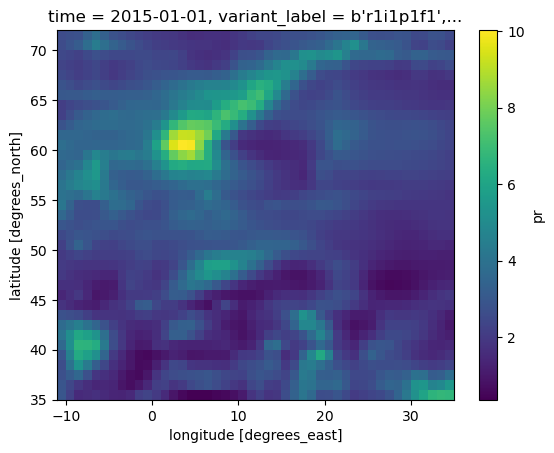

In [117]:
(cmip6_ssp585["pr"].sel(member="ACCESS-CM2_r1i1p1f1").isel(time=0) * 2880).plot()

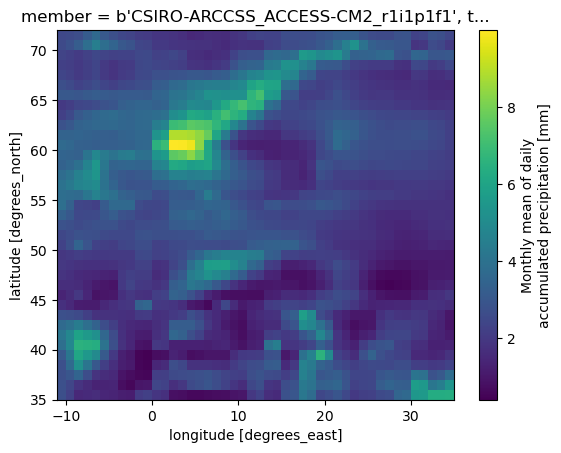

In [118]:
iad["pr"].sel(member=b'CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1').isel(time=0).plot()

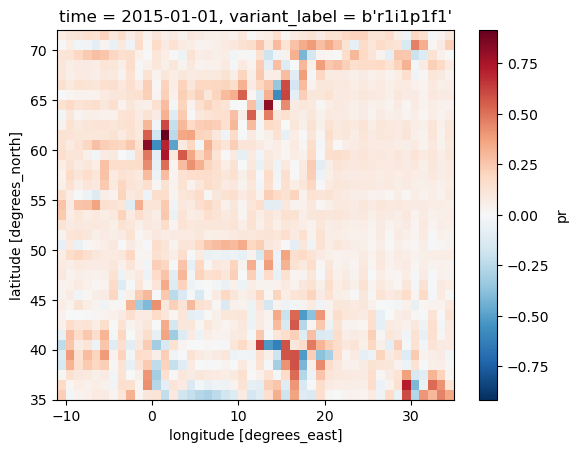

In [120]:
(
    cmip6_ssp585["pr"].sel(member="ACCESS-CM2_r1i1p1f1").isel(time=0) * 2880 -
    iad["pr"].sel(member=b'CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1').isel(time=0)
).plot()

# Playing

Acumulado mensual entre esgf e iad? Lo q pasa es el de esgf en cell_methods tiene `time: mean` y el iad es sum within days.

In [18]:
86400 / 30

2880.0

# Interpolate, we need target grid.

In [126]:
iad_catalog = pd.read_csv("https://raw.githubusercontent.com/SantanderMetGroup/IPCC-Atlas-Datalab/refs/heads/main/data_inventory.csv")
iad_subset = iad_catalog.query('type == "opendap" & variable == "pr" & project == "CMIP6" & experiment == "ssp585" & frequency == "mon"')
iad_location = iad_subset["location"].iloc[0]
iad_location

'https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CMIP6/ssp585/pr_CMIP6_ssp585_mon_201501-210012.nc'

In [127]:
iad = xarray.open_dataset(iad_location).sel(lat=lats, lon=lons)
iad["member"] = [b"_".join(member.split(b"_")[1:]).decode("ascii") for member in iad["member"].values]
iad["pr"]

<xarray.DataArray 'pr' (member: 33, time: 1032, lat: 37, lon: 46)> Size: 232MB
[57963312 values with dtype=float32]
Coordinates:
  * member   (member) <U24 3kB 'ACCESS-CM2_r1i1p1f1' ... 'UKESM1-0-LL_r1i1p1f2'
  * time     (time) datetime64[ns] 8kB 2015-01-01 2015-02-01 ... 2100-12-01
  * lat      (lat) float64 296B 35.5 36.5 37.5 38.5 39.5 ... 68.5 69.5 70.5 71.5
  * lon      (lon) float64 368B -10.5 -9.5 -8.5 -7.5 ... 31.5 32.5 33.5 34.5
Attributes:
    standard_name:  lwe_thickness_of_precipitation_amount
    units:          mm
    cell_methods:   time: sum within days time: mean over days area: mean
    long_name:      Monthly mean of daily accumulated precipitation
    comment:        Monthly mean of daily accumulated precipitation of liquid...
    grid_mapping:   crs
    _ChunkSizes:    [  1   1 180 360]

In [129]:
cmip6_ssp585

<xarray.Dataset> Size: 267MB
Dimensions:        (member: 19, time: 1032, lat: 37, lon: 46)
Coordinates:
  * time           (time) datetime64[ns] 8kB 2015-01-01 ... 2100-12-01
  * lat            (lat) float64 296B 35.5 36.5 37.5 38.5 ... 69.5 70.5 71.5
  * lon            (lon) float64 368B -10.5 -9.5 -8.5 -7.5 ... 32.5 33.5 34.5
    variant_label  (member) |S64 1kB b'r1i1p1f1' b'r1i1p1f1' ... b'r1i1p1f1'
  * member         (member) <U24 2kB 'ACCESS-CM2_r1i1p1f1' ... 'TaiESM1_r1i1p...
Data variables:
    pr             (member, time, lat, lon) float64 267MB 0.001023 ... 0.001335
Attributes: (12/53)
    Conventions:            
    activity_id:            ScenarioMIP
    branch_method:          no parent
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    creation_date:          
    ...                     ...
    size:                   2147483647
    size_human:             3.0 GiB
    __info__:               Virtual dataset generated by the ESGF Virtual Agg...
    __license__:            This is a derived dataset product from ESGF, same...
    replica:                1
    model_run:              ACCESS-CM2_r1i1p1f1

In [130]:
common_members = [x for x in iad["member"].values if x in cmip6_ssp585["member"].values]

In [131]:
common_members

['ACCESS-CM2_r1i1p1f1',
 'ACCESS-ESM1-5_r1i1p1f1',
 'CAMS-CSM1-0_r2i1p1f1',
 'CESM2-WACCM_r1i1p1f1',
 'CMCC-CM2-SR5_r1i1p1f1',
 'CNRM-CM6-1-HR_r1i1p1f2',
 'CNRM-CM6-1_r1i1p1f2',
 'CNRM-ESM2-1_r1i1p1f2',
 'CanESM5_r1i1p1f1',
 'EC-Earth3_r1i1p1f1',
 'FGOALS-g3_r1i1p1f1',
 'HadGEM3-GC31-LL_r1i1p1f3',
 'IITM-ESM_r1i1p1f1',
 'IPSL-CM6A-LR_r1i1p1f1',
 'MIROC-ES2L_r1i1p1f2',
 'MPI-ESM1-2-HR_r1i1p1f1',
 'NorESM2-LM_r1i1p1f1',
 'TaiESM1_r1i1p1f1']

# Pangeo

In [67]:
pangeo_catalog = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
pangeo_catalog.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [113]:
locations_pangeo = []
locations_esgfva = []

for model in versions.keys():
    member = members[model]
    subset = pangeo_catalog.query(f"source_id == '{model}' & table_id == 'day' & variable_id == 'pr' & experiment_id == 'ssp585' & member_id == '{members[model]}'")
    if len(subset) > 0:
        locations_pangeo.append(subset["zstore"].iloc[0])
    else:
        print(f"Missing Pangeo {model}")

    pangeo_version = locations_pangeo[-1].split("/")[-2]
    subset = esgf_va_catalog.query(f"project == 'CMIP6' & model == '{model}' & table == 'day' & variable == 'pr' & experiment == 'ssp585' & version == '{pangeo_version}'")
    if len(subset) > 0:
        locations_esgfva.append(subset["location"].iloc[0])
    else:
        print(f"Missing ESGF-VA {model}")

In [116]:
len(locations_pangeo), len(locations_esgfva)

(19, 19)

In [117]:
locations_pangeo[0], locations_esgfva[0]

('gs://cmip6/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp585/r1i1p1f1/day/pr/gn/v20210317/',
 'https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp585_day_gn_v20210317/CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp585_day_pr_gn_v20210317.ncml')

Check if shapes match.

In [ ]:
for esgfva_location, pangeo_location in list(zip(locations_esgfva, locations_pangeo)):
    try:
        esgfva = xarray.open_dataset(esgfva_location)
        pangeo = xarray.open_zarr(pangeo_location)
    
        print(esgfva["pr"].sel(variant_label=members[esgfva.attrs["source_id"]].encode("ascii")).shape, pangeo["pr"].shape)
    except:
        print("Error, continue...")

/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/coding/times.py:1005: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/coding/times.py:1005: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/core/indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/codi

(104459, 144, 192) (18262, 144, 192)


/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/coding/times.py:1005: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/coding/times.py:1005: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/core/indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/codi

(104459, 145, 192) (104459, 145, 192)


oc_open: server error retrieving url: code=500 message="http://esgf3.dkrz.de/thredds/dodsC/cmip6/ScenarioMIP/AWI/AWI-CM-1-1-MR/ssp585/r1i1p1f1/day/pr/gn/v20190529/pr_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20990101-20991231.nc is not a valid URL, return status=404"

Error, continue...


oc_open: server error retrieving url: code=500 message="http://esg.camscma.cn/thredds/dodsC/cmip6/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/ssp585/r2i1p1f1/day/pr/gn/v20191106/pr_day_CAMS-CSM1-0_ssp585_r2i1p1f1_gn_20150101-20991231.nc is not a valid URL, return status=400"

Error, continue...
(31390, 64, 128) (60590, 64, 128)


oc_open: server error retrieving url: code=500 message="http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/day/pr/gn/v20200702/pr_day_CESM2-WACCM_ssp585_r1i1p1f1_gn_22810101-22901231.nc is not a valid URL, return status=400"

Error, continue...


oc_open: server error retrieving url: code=500 message="org.apache.http.conn.ConnectTimeoutException: Connect to esgf-node2.cmcc.it:80 [esgf-node2.cmcc.it/193.204.199.223] failed: Connect timed out"

Error, continue...
